# Histopathologic Cancer Detection

## 1. Introduction
This notebook addresses the Kaggle Histopathologic Cancer Detection challenge. The goal is to identify metastatic cancer in small image patches from digital pathology scans. This is a binary image classification problem.

## 2. Data Description
- The dataset consists of small image patches (96x96 pixels).
- Each image is labeled as 1 (cancer) or 0 (no cancer).
- Labels are provided in a CSV file.
- Images are stored in folders.

### 3. Exploratory Data Analysis (EDA)
- Display sample images from each class.
- Visualize class distribution.
- Check for missing data.

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt


DATA_DIR = 'data'
LABELS_PATH = 'data/train_labels.csv'

In [17]:

# Basic EDA 

labels_df = pd.read_csv(LABELS_PATH)
labels_df.info()

labels_df.columns

print(labels_df['label'].value_counts())

# Check if there are any null values in the dataset; there should be none
labels_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
label
0    130908
1     89117
Name: count, dtype: int64


id       0
label    0
dtype: int64

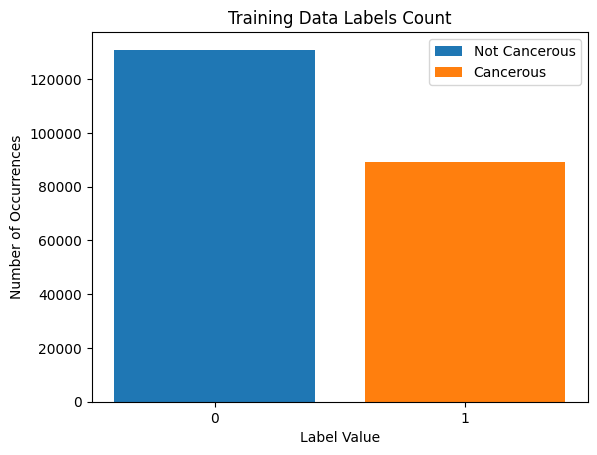

In [18]:
plt.bar('0', len(labels_df[labels_df['label'] == 0]))
plt.bar('1', len(labels_df[labels_df['label'] == 1]))
plt.xlabel("Label Value")
plt.ylabel("Number of Occurrences")
plt.title("Training Data Labels Count")
plt.legend(['Not Cancerous', 'Cancerous'])
plt.show()

## 4. Data Preprocessing
- Image loading and resizing.
- Data augmentation.
- Train/validation split.

In [19]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)
print(f'Train size: {len(train_df)}, Validation size: {len(val_df)}')

Train size: 176020, Validation size: 44005


## 5. Model Building
- Define a CNN or use transfer learning.
- Show model architecture.

In [24]:
# Example: Simple CNN with Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.summary()

/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/CNN/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,681 (1.57 MB)

 Trainable params: 411,681 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training
- Compile and train the model.
- Show training/validation accuracy and loss.

In [29]:
# Compile the model
# Example data generators (update paths and parameters as needed)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Helper function to get file path from id
def get_image_path(image_id):
    return os.path.join(DATA_DIR, 'train', f"{image_id}.tif")

# Add a column with full image paths
train_df['path'] = train_df['id'].apply(get_image_path)
val_df['path'] = val_df['id'].apply(get_image_path)

# Custom generator using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='raw',
    batch_size=128,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='raw',
    batch_size=128,
    shuffle=False
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Adjust as needed
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,verbose=1, mode='max', min_lr=0.00001)
    ]
)

Found 176020 validated image filenames.
Found 44005 validated image filenames.
Epoch 1/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 605s 438ms/step - accuracy: 0.7646 - loss: 0.4963 - val_accuracy: 0.8066 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 2/5


/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/CNN/env/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 639s 464ms/step - accuracy: 0.8070 - loss: 0.4312 - val_accuracy: 0.8395 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 3/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 562s 408ms/step - accuracy: 0.8307 - loss: 0.3876 - val_accuracy: 0.8471 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 4/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 587s 427ms/step - accuracy: 0.8456 - loss: 0.3617 - val_accuracy: 0.8519 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 5/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 597s 434ms/step - accuracy: 0.8505 - loss: 0.3488 - val_accuracy: 0.8585 - val_loss: 0.3307 - learning_rate: 0.0010


## 6. Results

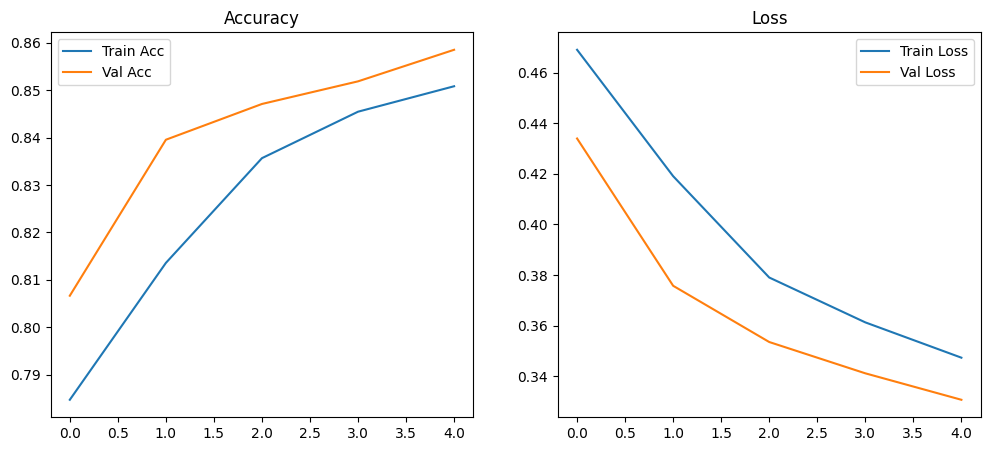

344/344 ━━━━━━━━━━━━━━━━━━━━ 61s 176ms/step - accuracy: 0.8570 - loss: 0.3321
Validation Loss: 0.3307, Validation Accuracy: 0.8585
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step
Confusion Matrix:
 [[23586  2596]
 [ 3630 14193]]
ROC AUC: 0.9314


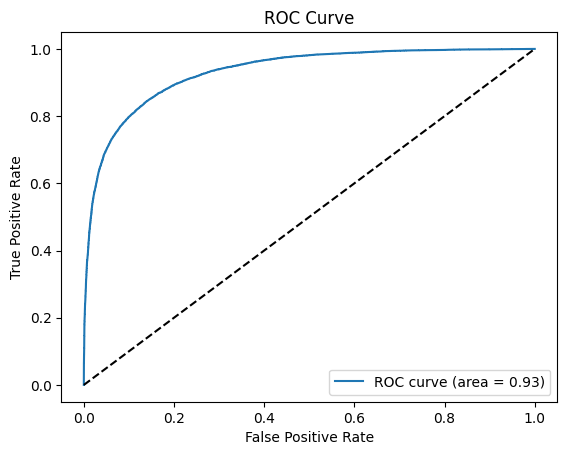

In [30]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Optional: Confusion matrix and ROC curve
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import numpy as np

# Get predictions
val_preds = model.predict(val_generator)
val_pred_labels = (val_preds > 0.5).astype(int).flatten()
true_labels = val_df['label'].values

# Confusion matrix
cm = confusion_matrix(true_labels, val_pred_labels)
print("Confusion Matrix:\n", cm)

# ROC AUC
roc_auc = roc_auc_score(true_labels, val_preds)
print(f"ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, val_preds)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()